# Feature extraction
## Detecting cancer from histopatological images
In this tutorial we will apply feature extractors to detect cancer in histopatological images of breast tissue. We will use selected images from the PatchCamelyon dataset https://github.com/basveeling/pcam.
<img src="images/pcam.jpg" style="max-width:100%; width: 100%; max-width: none">

### Load the dataset

Run the code below to load the dataset from the file `histological_data.npz`.

In [1]:
import numpy as np

# Load dataset from .npz file
data = np.load('datasets/histological_data.npz')

# Train images and labels
X_train = data['X_train']
y_train = data['y_train'].astype('int')

# Test images and labels
X_test  = data['X_test']
y_test  = data['y_test'].astype('int')

# Print shapes here
print('Training data - images:', X_train.shape)
print('Training data - labels:',y_train.shape)
print('Test data - images:',X_test.shape)
print('Test data - labels:',y_test.shape)
print('Labels: ', np.unique(y_test))

Training data - images: (1500, 96, 96)
Training data - labels: (1500,)
Test data - images: (150, 96, 96)
Test data - labels: (150,)
Labels:  [0 1]


**Activity 1:** Answer the following questions:
* How many training samples we have?
* How many test samples we have?
* What is the dimension of each sample image?
* How many labels we have?

**Answer:** We have 1500 training and 150 test samples. Each sample image is 96x96 pixels. We have labels 0 and 1.

Let's now plot a few example histopathological images. Note that label 1 means presence of cancerous cells.

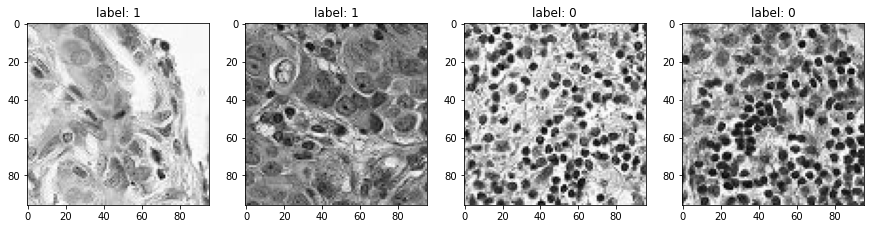

In [2]:
import matplotlib.pyplot as plt

id_images = [4, 5, 6, 7]

plt.figure(figsize=(15, 8))
for i in np.arange(0, 4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_train[id_images[i], :, :], cmap='gray')
    plt.title('label: ' + str(y_train[id_images[i]]))

# Cancer detection using texture descriptors

We will now calculate the texture descriptors using **Grey-level co-ocurrence matrix (GLCM)**. The matrix can be calculated using `skimage` object `greycomatrix`.

We will select one healthy and one cancerous sample image. The GLCM for the healthy sample has been generated and plotted for you. 

**Activity 2:** Do the same for the cancerous sample. Do the matrices look different? Can you think why?

**Answer:** It apears that there is more local contrast in the healthy compared to cancerous tissue.

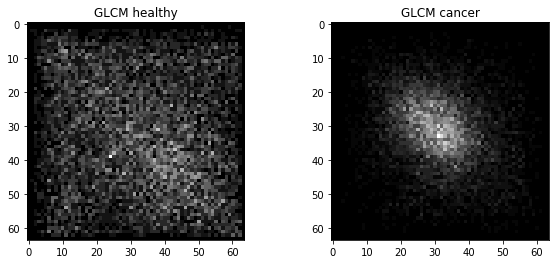

In [3]:
# example images
healthy = X_train[7, :, :] 
cancer = X_train[5, :, :] 

# calculate and plot GLCM
from skimage.feature import greycomatrix

plt.figure(figsize=(10,4))

plt.subplot(121)
glcm_healthy = greycomatrix(np.round(healthy*63).astype('uint8'), [3], [0],64)
plt.imshow(glcm_healthy.reshape(64,64), cmap='gray')
plt.title('GLCM healthy')

plt.subplot(122)
glcm_cancer = greycomatrix(np.round(cancer*63).astype('int'), [3], [0], 64)
plt.imshow(glcm_cancer.reshape(64,64), cmap='gray')
_=plt.title('GLCM cancer')

Now we can calculate some statistical properties from the GLCM matrix. We can do that using `skimage` object `greycoprops`. Print out different statistical measures for the healthy and cancerous tissue:
* `'contrast'`
* `'dissimilarity'`
* `'homogeneity'`
* `'energy'`
* `'correlation'`

**Activity 3:** Complete the code below to generate all five measures for both healthy and cancerous samples.

In [4]:
from skimage.feature import greycoprops
properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']

for p in properties:
    print(p+': ')
    print('  healthy: ', np.round(greycoprops(glcm_healthy, p)[0,0], 2))
    print('  cancer: ', np.round(greycoprops(glcm_cancer, p)[0,0], 2))


contrast: 
  healthy:  439.54
  cancer:  145.64
dissimilarity: 
  healthy:  16.37
  cancer:  9.14
homogeneity: 
  healthy:  0.07
  cancer:  0.12
energy: 
  healthy:  0.02
  cancer:  0.03
correlation: 
  healthy:  0.12
  cancer:  0.24


## Exercise 4

In this exercise you will train a logistic regression classifier to detect cancer using GLCM features. Complete code below as follows:
* Extract two GLCM features of your choice. To do that, complete the function `getGLCMfeatures`. Feature extraction code is given.
* Fit the logistic regression model to the training data and calculate training performance using function `PerformanceMeasures`.
* Evaluate performance on the test data using function `PerformanceMeasures`.
* Amend features extracted in function `getGLCMfeatures` to achieve good performance of the model.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression

def getGLCMfeatures(im):
    im = np.round(im*63).astype('uint8')
    glcm = greycomatrix(im, [3], [0], 64)
    feature1 = greycoprops(glcm, 'contrast')[0, 0]
    feature2 = greycoprops(glcm, 'dissimilarity')[0, 0]    
    return feature1, feature2

def PerformanceMeasures(model,X,y): 

    accuracy = model.score(X,y)
    y_pred = model.predict(X)
    sensitivity = recall_score(y,y_pred)
    specificity = recall_score(y,y_pred,pos_label=0)

    print('Accuracy: ', round(accuracy,2))
    print('Sensitivity: ', round(sensitivity,2))
    print('Specificity: ', round(specificity,2))

# feature extraction
X_train_features = []
for im in X_train:
    X_train_features.append(getGLCMfeatures(im))
X_train_features = np.asarray(X_train_features)
scaler= StandardScaler()
X_train_features=scaler.fit_transform(X_train_features)

# fit model
model = LogisticRegression()
model.fit(X_train_features,y_train)
print('Training:')
PerformanceMeasures(model, X_train_features,y_train)

# test
X_test_features  = []
for im in X_test:
    X_test_features.append(getGLCMfeatures(im))
X_test_features  = np.asarray(X_test_features)
X_test_features=scaler.fit_transform(X_test_features)
print('Test:')
PerformanceMeasures(model, X_test_features,y_test)

Training:
Accuracy:  0.76
Sensitivity:  0.73
Specificity:  0.78
Test:
Accuracy:  0.79
Sensitivity:  0.8
Specificity:  0.78


# Cancer detection using localised feature descriptors

Now we will try to train a classifier using the DAISY descriptor instead. First, let's extract the DAISY features from the histological images. 


In the lectures we have seen a number of feature extractors that are available at `skimage`, including `daisy`. 

**Activity 4:** Run the code below to perform feature extraction using `skimage` object `daisy` and visualise your extracted features. 
* Change the parameters `step` and `radius` to see how the daisy extractor changes.
* Set `step` to 60 and `radius` to 30. Then try to change the other parameters of the DAISY descriptor.

Feature vector shape daisy:  (2, 2, 136)


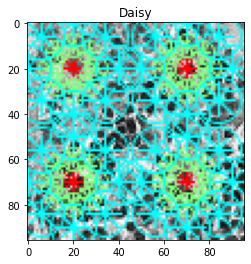

In [6]:
from skimage.feature import daisy

# example feature extraction using daisy
features_daisy, visualisation_daisy = daisy(healthy, step=50, radius=20, rings=2, histograms=8, orientations=8, visualize=True)
plt.imshow(visualisation_daisy)
plt.title('Daisy')
# Extracted features
print('Feature vector shape daisy: ', features_daisy.shape)

## Exercise 5

Train a classifier to detect cancer in histological images using features extracted by DAISY descriptor.
* Complete the function `daisy_feature_extractor`
* Run the code below to extract the daisy features for training and test sets. This may take a while to run.

In [7]:
# Feature extractor
def daisy_feature_extractor(image):    
    return daisy(image, step=30, radius=20, rings=2, histograms=8, orientations=8, visualize=False).flatten()

# Perform feature extraction for both training and test set

X_train_features = []
X_test_features  = []

# Go through all the images, perform feature extraction and then append them to the list
for img in X_train:
    X_train_features.append(daisy_feature_extractor(img))
for img in X_test:
    X_test_features.append(daisy_feature_extractor(img))
    
# Make the lists back into numpy arrays
X_train_features = np.asarray(X_train_features)
X_test_features  = np.asarray(X_test_features)

# Print dimensions
print('Feature matrix train: ', X_train_features.shape)
print('Feature matrix test: ', X_test_features.shape)

Feature matrix train:  (1500, 544)
Feature matrix test:  (150, 544)


* Train a random forest classifier to detect cancer
* Evaluate training and test performance

In [9]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(min_samples_leaf = 50) 
model.fit(X_train_features,y_train)
print('Training:')
PerformanceMeasures(model, X_train_features,y_train)
print('Test:')
PerformanceMeasures(model, X_test_features,y_test)

Training:
Accuracy:  0.8
Sensitivity:  0.65
Specificity:  0.9
Test:
Accuracy:  0.76
Sensitivity:  0.51
Specificity:  0.88


* Compare the performance to GLSM features

**Answer:** The performance is similar. However, for GLCM features, sensitivity and specificity was similar, but DAISY classifier has low sensitivity and high specificity.